# LSTM Autoencoder for Rare Event Binary Classification

This is a continuation of the regular autoencoder for rare event classification presented in
https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
and code present in
https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb
Here we will show an implementation of building a binary classifier using LSTM Autoencoders. 
Similar to the previous post, the purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

LSTM requires closer attention to preparing the data. Here we have all the steps, and few tests to validate the data preparation.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
tf.random.set_seed(2)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [6]:
df = pd.read_csv("combined_csv.csv") 
df.head(n=5) 

/var/folders/05/ntvwwb8x6tdf167m58_ryr800000gn/T/ipykernel_2241/2414607687.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_csv.csv")


,Unnamed: 0,_time,VFD1,VFD2,VFD3,VFD4,Success?,Anomally,Description,Cycle_Number,...,TJointAngle_R03,UJointAngle_R03,LoadCell_R04,Potentiometer_R04,BJointAngle_R04,LJointAngle_R04,RJointAngle_R04,SJointAngle_R04,TJointAngle_R04,UJointAngle_R04
0,0,2023-09-19T14:21:53.393Z,32.065132,89.130089,77.845947,-2.330000e-09,Y,N,NaN,1.0,...,0.002151,0.0,2640,11855,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
1,1,2023-09-19T14:21:53.485Z,32.065132,89.130089,77.630096,7.803271e+01,Y,N,NaN,1.0,...,0.002151,0.0,2643,11908,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
2,2,2023-09-19T14:21:53.582Z,32.065132,89.130089,77.630096,7.803271e+01,Y,N,NaN,1.0,...,0.002151,0.0,2659,11939,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
3,3,2023-09-19T14:21:53.687Z,32.065132,89.130089,77.630096,7.803271e+01,Y,N,NaN,1.0,...,0.002151,0.0,2612,11932,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
4,4,2023-09-19T14:21:53.793Z,32.065132,89.130089,77.630096,7.803271e+01,Y,N,NaN,1.0,...,0.002151,0.0,2630,11931,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621


In [7]:
df['Anomally'] = df['Anomally'].replace({'N': 0, 'Y': 1})
df
df=df.rename(columns={"Success?": "Success"})

df['Success'] = df['Success'].replace({'N': 0, 'Y': 1})
df

,Unnamed: 0,_time,VFD1,VFD2,VFD3,VFD4,Success,Anomally,Description,Cycle_Number,...,TJointAngle_R03,UJointAngle_R03,LoadCell_R04,Potentiometer_R04,BJointAngle_R04,LJointAngle_R04,RJointAngle_R04,SJointAngle_R04,TJointAngle_R04,UJointAngle_R04
0,0,2023-09-19T14:21:53.393Z,32.065132,89.130089,77.845947,-2.330000e-09,1,0,NaN,1.0,...,0.002151,0.0,2640,11855,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
1,1,2023-09-19T14:21:53.485Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2643,11908,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
2,2,2023-09-19T14:21:53.582Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2659,11939,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
3,3,2023-09-19T14:21:53.687Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2612,11932,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
4,4,2023-09-19T14:21:53.793Z,32.065132,89.130089,77.630096,7.803271e+01,1,0,NaN,1.0,...,0.002151,0.0,2630,11931,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211540,211540,2023-09-19T20:14:30.591Z,32.065441,131.260925,102.130470,1.028948e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,2959,11864,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
211541,211541,2023-09-19T20:14:30.691Z,32.065441,131.260925,102.130470,1.029058e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,3221,11966,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
211542,211542,2023-09-19T20:14:30.787Z,32.065441,131.260925,102.130470,1.029167e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,2467,11801,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
211543,211543,2023-09-19T20:14:30.883Z,32.065441,131.260925,102.130470,1.029277e+02,1,1,BothBodies and Nose Removed,71.0,...,-0.002151,0.0,3176,11923,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621


### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [8]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['Anomally'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'Anomally'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [9]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['Anomally'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,Unnamed: 0,_time,VFD1,VFD2,VFD3
15744,15744,2023-09-19T14:48:07.791Z,32.065319,113.630241,87.630249
15745,15745,2023-09-19T14:48:08.127Z,32.065319,113.630241,87.630249
15746,15746,2023-09-19T14:48:08.128Z,32.065319,113.630241,87.630249
15747,15747,2023-09-19T14:48:08.130Z,32.065319,113.630241,87.630249
15748,15748,2023-09-19T14:48:08.181Z,32.065319,113.630241,87.630249


After shifting


,Anomally,Unnamed: 0,_time,VFD1,VFD2
15743,0.0,15743,2023-09-19T14:48:07.673Z,32.065319,113.630241
15744,0.0,15744,2023-09-19T14:48:07.791Z,32.065319,113.630241
15745,1.0,15745,2023-09-19T14:48:08.127Z,32.065319,113.630241
15746,1.0,15746,2023-09-19T14:48:08.128Z,32.065319,113.630241
15852,0.0,15852,2023-09-19T14:48:18.579Z,32.065323,114.130241


In [10]:
# Remove time column, and the categorical columns
df = df.drop(['_time', 'Unnamed: 0', 'Description'], axis=1)

In [11]:
df

,Anomally,VFD1,VFD2,VFD3,VFD4,Success,Cycle_Number,LoadCell_R01,Potentiometer_R01,Cycle_Count,...,TJointAngle_R03,UJointAngle_R03,LoadCell_R04,Potentiometer_R04,BJointAngle_R04,LJointAngle_R04,RJointAngle_R04,SJointAngle_R04,TJointAngle_R04,UJointAngle_R04
0,0.0,32.065132,89.130089,77.845947,-2.330000e-09,1,1.0,1431,11574,1,...,0.002151,0.0,2640,11855,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
1,0.0,32.065132,89.130089,77.630096,7.803271e+01,1,1.0,1424,11613,1,...,0.002151,0.0,2643,11908,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
2,0.0,32.065132,89.130089,77.630096,7.803271e+01,1,1.0,1483,11671,1,...,0.002151,0.0,2659,11939,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
3,0.0,32.065132,89.130089,77.630096,7.803271e+01,1,1.0,1494,11669,1,...,0.002151,0.0,2612,11932,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
4,0.0,32.065132,89.130089,77.630096,7.803271e+01,1,1.0,1494,11663,1,...,0.002151,0.0,2630,11931,-0.005493,0.781131,0.0,-90.0,-0.002151,0.786621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188882,0.0,32.065426,127.630486,103.630501,1.046636e+02,1,63.0,1426,11638,42,...,-0.002151,0.0,2736,11956,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
188883,0.0,32.065426,127.630486,103.630501,1.046636e+02,1,63.0,1434,11629,42,...,-0.002151,0.0,2621,11827,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
188884,0.0,32.065426,127.630486,103.630501,1.046526e+02,1,63.0,1459,11613,42,...,-0.002151,0.0,2696,11907,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621
188885,1.0,32.065426,127.630486,103.630501,1.046526e+02,1,63.0,1423,11601,42,...,-0.002151,0.0,2643,11873,-0.005493,0.781131,0.0,-90.0,0.000000,0.786621


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181846 entries, 0 to 188886
Data columns (total 40 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Anomally           181846 non-null  float64
 1   VFD1               181846 non-null  float64
 2   VFD2               181846 non-null  float64
 3   VFD3               181846 non-null  float64
 4   VFD4               181846 non-null  float64
 5   Success            181846 non-null  int64  
 6   Cycle_Number       181846 non-null  float64
 7   LoadCell_R01       181846 non-null  int64  
 8   Potentiometer_R01  181846 non-null  int64  
 9   Cycle_Count        181846 non-null  int64  
 10  BJointAngle_R01    181846 non-null  float64
 11  LJointAngle_R01    181846 non-null  float64
 12  RJointAngle_R01    181846 non-null  float64
 13  SJointAngle_R01    181846 non-null  float64
 14  TJointAngle_R01    181846 non-null  float64
 15  UJointAngle_R01    181846 non-null  float64
 16  Lo

In [13]:
input_X = df.loc[:, df.columns != 'Anomally'].values  # converts the df to a numpy array
input_y = df['Anomally'].values

n_features = input_X.shape[1]  # number of features

In [14]:
n_features

39

In [15]:
input_y

array([0., 0., 0., ..., 0., 1., 1.])

In [16]:
input_X

array([[ 3.20651321e+01,  8.91300888e+01,  7.78459473e+01, ...,
        -9.00000000e+01, -2.15116900e-03,  7.86620915e-01],
       [ 3.20651321e+01,  8.91300888e+01,  7.76300964e+01, ...,
        -9.00000000e+01, -2.15116900e-03,  7.86620915e-01],
       [ 3.20651321e+01,  8.91300888e+01,  7.76300964e+01, ...,
        -9.00000000e+01, -2.15116900e-03,  7.86620915e-01],
       ...,
       [ 3.20654259e+01,  1.27630486e+02,  1.03630501e+02, ...,
        -9.00000000e+01,  0.00000000e+00,  7.86620915e-01],
       [ 3.20654259e+01,  1.27630486e+02,  1.03630501e+02, ...,
        -9.00000000e+01,  0.00000000e+00,  7.86620915e-01],
       [ 3.20654259e+01,  1.27630486e+02,  1.03630501e+02, ...,
        -9.00000000e+01,  0.00000000e+00,  7.86620915e-01]])

In [17]:
n_features

39

In [18]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [19]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,Anomally,VFD1,VFD2,VFD3,VFD4,Success,Cycle_Number,LoadCell_R01,Potentiometer_R01,Cycle_Count,...,TJointAngle_R03,UJointAngle_R03,LoadCell_R04,Potentiometer_R04,BJointAngle_R04,LJointAngle_R04,RJointAngle_R04,SJointAngle_R04,TJointAngle_R04,UJointAngle_R04
15740,0.0,32.065319,113.630241,87.630249,88.392822,1,6.0,1497,11591,6,...,-23.359543,-6.040282,2832,12010,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
15741,0.0,32.065319,113.630241,87.630249,88.392822,1,6.0,1438,11576,6,...,-23.497217,-6.136961,3073,11898,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
15742,0.0,32.065319,113.630241,87.630249,88.381836,1,6.0,1427,11615,6,...,-23.497217,-6.136961,2813,11884,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
15743,0.0,32.065319,113.630241,87.630249,88.381836,1,6.0,1457,11580,6,...,-23.497217,-6.136961,2829,11861,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
15744,0.0,32.065319,113.630241,87.630249,88.381836,1,6.0,1439,11652,6,...,-23.497217,-6.144652,2693,11957,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
15745,1.0,32.065319,113.630241,87.630249,88.381836,1,6.0,1481,11639,6,...,-23.488611,-6.260008,2644,11762,-0.005493,0.781131,0.0,-90.0,0.0,0.786621


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,32.065319,113.630241,87.630249,88.392822,1.0,6.0,1438.0,11576.0,6.0,-90.001137,...,-23.497217,-6.136961,3073.0,11898.0,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
1,32.065319,113.630241,87.630249,88.381836,1.0,6.0,1427.0,11615.0,6.0,-90.001137,...,-23.497217,-6.136961,2813.0,11884.0,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
2,32.065319,113.630241,87.630249,88.381836,1.0,6.0,1457.0,11580.0,6.0,-90.001137,...,-23.497217,-6.136961,2829.0,11861.0,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
3,32.065319,113.630241,87.630249,88.381836,1.0,6.0,1439.0,11652.0,6.0,-90.001137,...,-23.497217,-6.144652,2693.0,11957.0,-0.005493,0.781131,0.0,-90.0,0.0,0.786621
4,32.065319,113.630241,87.630249,88.381836,1.0,6.0,1481.0,11639.0,6.0,-90.001137,...,-23.488611,-6.260008,2644.0,11762.0,-0.005493,0.781131,0.0,-90.0,0.0,0.786621


The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to predict y(t).

In [20]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)


In [21]:
X_train.shape

(116377, 5, 1, 39)

In [22]:
np.array(y)

array([0., 0., 0., ..., 0., 1., 1.])

In [23]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [24]:
X_train_y0.shape

(116363, 5, 1, 39)

In [25]:
X_valid_y0.shape

(29093, 5, 1, 39)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [26]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [27]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [28]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [29]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [30]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0.  0.  0. -0.  0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.
 -0. -0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0.
 -0. -0.  0.]
colwise variance [1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


The test succeeded. Now we will _scale_ the validation and test sets.

In [31]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

In [32]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

epochs = 200
batch = 64
lr = 0.0001

In [33]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

2023-10-12 14:33:41.993335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             9216      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 5, 16)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 16)             2112      
                                                                 
 lstm_3 (LSTM)               (None, 5, 32)             6272      
                                                                 
 time_distributed (TimeDistr  (None, 5, 39)            1287      
 ibuted)                                                

In [34]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier_mcnair.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

Epoch 1/200
1819/1819 - 16s - loss: 0.6306 - val_loss: 0.4197 - 16s/epoch - 9ms/step
Epoch 2/200
1819/1819 - 13s - loss: 0.3364 - val_loss: 0.3004 - 13s/epoch - 7ms/step
Epoch 3/200
1819/1819 - 13s - loss: 0.2623 - val_loss: 0.2538 - 13s/epoch - 7ms/step
Epoch 4/200
1819/1819 - 13s - loss: 0.2256 - val_loss: 0.2240 - 13s/epoch - 7ms/step
Epoch 5/200
1819/1819 - 13s - loss: 0.2038 - val_loss: 0.2087 - 13s/epoch - 7ms/step
Epoch 6/200
1819/1819 - 13s - loss: 0.1925 - val_loss: 0.2002 - 13s/epoch - 7ms/step
Epoch 7/200
1819/1819 - 13s - loss: 0.1855 - val_loss: 0.1943 - 13s/epoch - 7ms/step
Epoch 8/200
1819/1819 - 13s - loss: 0.1806 - val_loss: 0.1909 - 13s/epoch - 7ms/step
Epoch 9/200
1819/1819 - 13s - loss: 0.1770 - val_loss: 0.1871 - 13s/epoch - 7ms/step
Epoch 10/200
1819/1819 - 13s - loss: 0.1742 - val_loss: 0.1844 - 13s/epoch - 7ms/step
Epoch 11/200
1819/1819 - 13s - loss: 0.1716 - val_loss: 0.1818 - 13s/epoch - 7ms/step
Epoch 12/200
1819/1819 - 13s - loss: 0.1691 - val_loss: 0.1794 

Epoch 97/200
1819/1819 - 13s - loss: 0.0872 - val_loss: 0.1006 - 13s/epoch - 7ms/step
Epoch 98/200
1819/1819 - 13s - loss: 0.0868 - val_loss: 0.0999 - 13s/epoch - 7ms/step
Epoch 99/200
1819/1819 - 13s - loss: 0.0867 - val_loss: 0.1001 - 13s/epoch - 7ms/step
Epoch 100/200
1819/1819 - 13s - loss: 0.0865 - val_loss: 0.0998 - 13s/epoch - 7ms/step
Epoch 101/200
1819/1819 - 13s - loss: 0.0861 - val_loss: 0.0997 - 13s/epoch - 7ms/step
Epoch 102/200
1819/1819 - 13s - loss: 0.0859 - val_loss: 0.1001 - 13s/epoch - 7ms/step
Epoch 103/200
1819/1819 - 13s - loss: 0.0858 - val_loss: 0.1003 - 13s/epoch - 7ms/step
Epoch 104/200
1819/1819 - 13s - loss: 0.0857 - val_loss: 0.0989 - 13s/epoch - 7ms/step
Epoch 105/200
1819/1819 - 67s - loss: 0.0855 - val_loss: 0.0994 - 67s/epoch - 37ms/step
Epoch 106/200
1819/1819 - 13s - loss: 0.0851 - val_loss: 0.0990 - 13s/epoch - 7ms/step
Epoch 107/200
1819/1819 - 14s - loss: 0.0847 - val_loss: 0.0987 - 14s/epoch - 7ms/step
Epoch 108/200
1819/1819 - 13s - loss: 0.0914 

Epoch 192/200
1819/1819 - 11s - loss: 0.0708 - val_loss: 0.0868 - 11s/epoch - 6ms/step
Epoch 193/200
1819/1819 - 11s - loss: 0.0707 - val_loss: 0.0876 - 11s/epoch - 6ms/step
Epoch 194/200
1819/1819 - 11s - loss: 0.0707 - val_loss: 0.0848 - 11s/epoch - 6ms/step
Epoch 195/200
1819/1819 - 11s - loss: 0.0706 - val_loss: 0.0865 - 11s/epoch - 6ms/step
Epoch 196/200
1819/1819 - 11s - loss: 0.0757 - val_loss: 0.0861 - 11s/epoch - 6ms/step
Epoch 197/200
1819/1819 - 11s - loss: 0.0713 - val_loss: 0.0863 - 11s/epoch - 6ms/step
Epoch 198/200
1819/1819 - 11s - loss: 0.0703 - val_loss: 0.0853 - 11s/epoch - 6ms/step
Epoch 199/200
1819/1819 - 11s - loss: 0.0702 - val_loss: 0.0859 - 11s/epoch - 6ms/step
Epoch 200/200
1819/1819 - 11s - loss: 0.0703 - val_loss: 0.0860 - 11s/epoch - 6ms/step


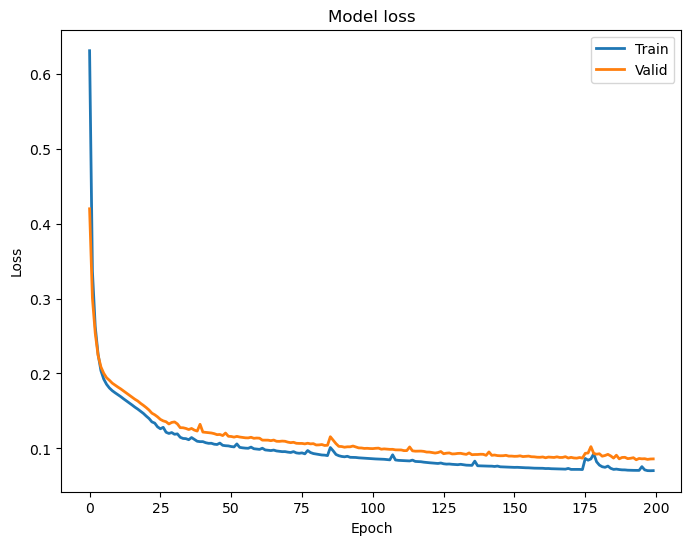

In [35]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Sanity check
Doing a sanity check by validating the reconstruction error 
on the train data. Here we will reconstruct the entire train 
data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should
be smaller than 1.

**Caution**: do not use this result for model evaluation. It may
result into overfitting issues.

3637/3637 [==============================] - 6s 2ms/step


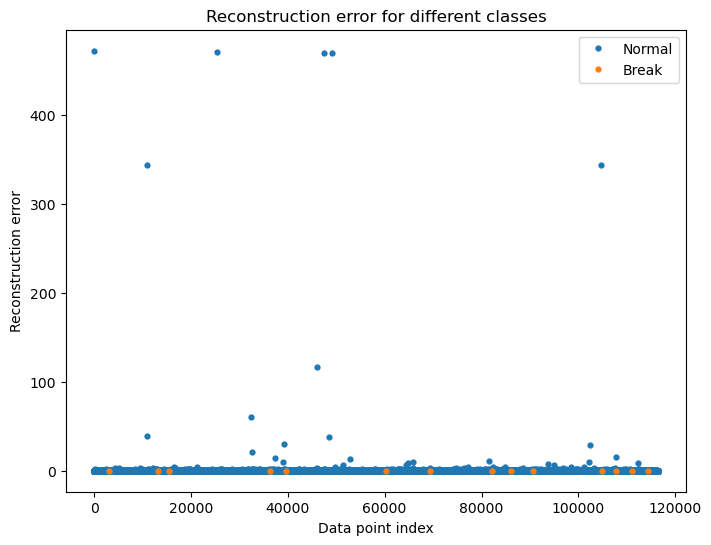

In [36]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = np.mean(np.power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

## Predictions using the Autoencoder

910/910 [==============================] - 1s 2ms/step


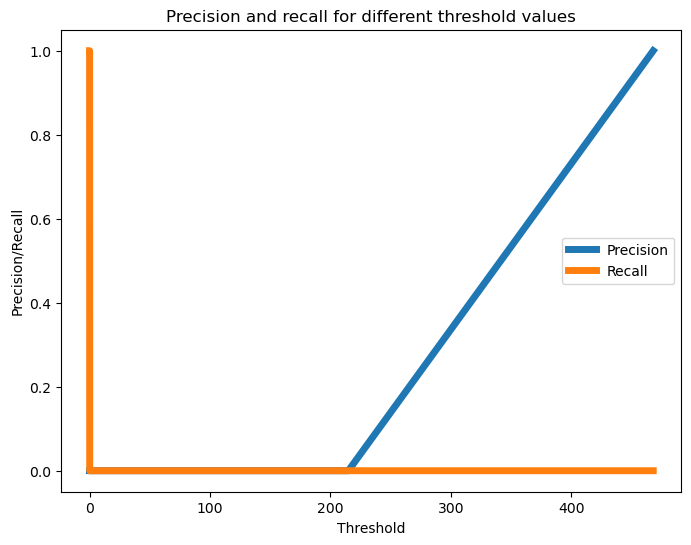

In [37]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = np.mean(np.power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

1137/1137 [==============================] - 2s 2ms/step


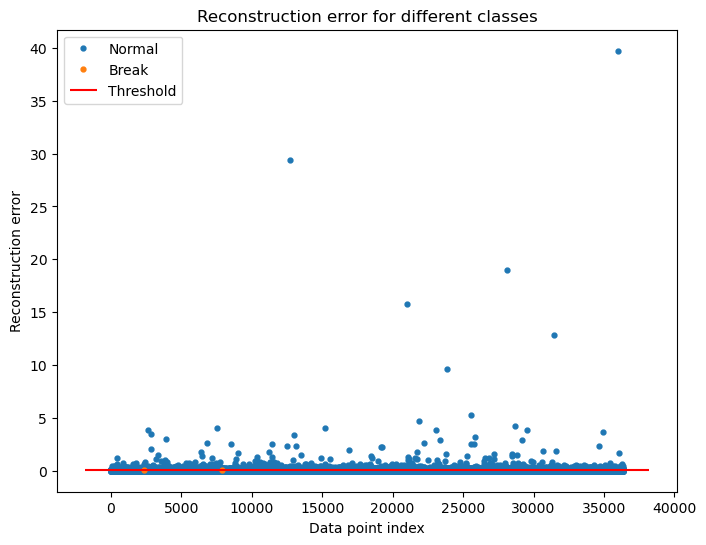

In [55]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.05
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [56]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

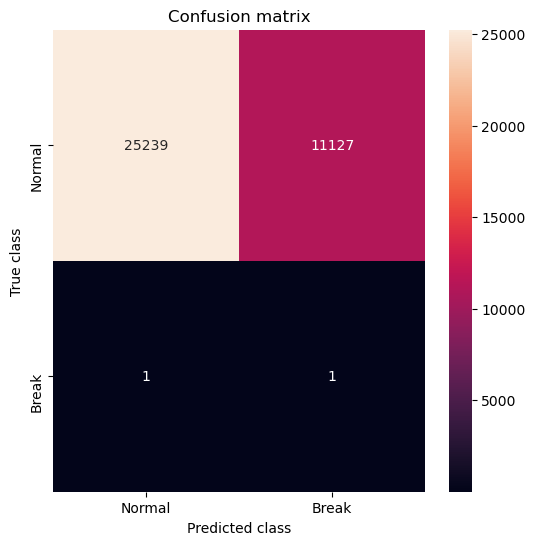

In [57]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [58]:
target_names = ['Normal', 'Break']

print(classification_report(error_df.True_class, pred_y, target_names=target_names))

              precision    recall  f1-score   support

      Normal       1.00      0.69      0.82     36366
       Break       0.00      0.50      0.00         2

    accuracy                           0.69     36368
   macro avg       0.50      0.60      0.41     36368
weighted avg       1.00      0.69      0.82     36368



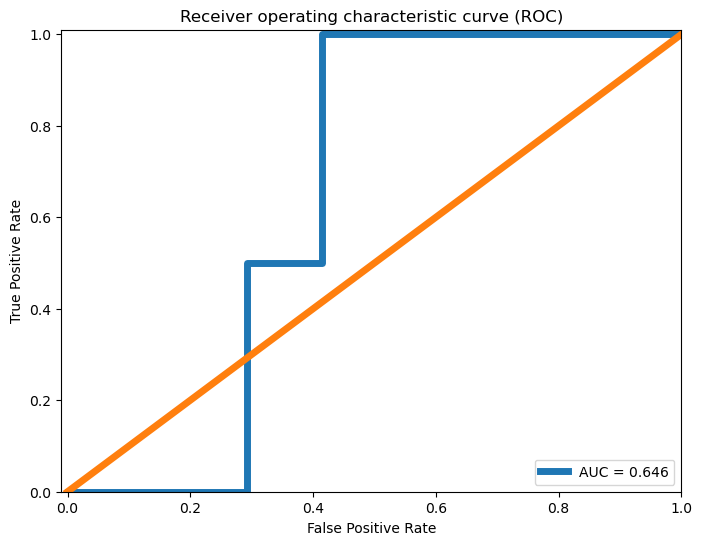

In [59]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()